# Lab 7 Exploration: AR Markers

In this notebook, we will learn how to use OpenCv functions to identify AR markers and write a function to determine their orientation using their coordinates.

Throughout this notebook, **<font style="color:red">text in bold red</font>** indicates a change you must make to the following code block before running it.

## Table of Contents
1. [Getting Started](#GettingStarted)
1. [Locating AR Markers](#LocatingARMarkers)
1. [Using Marker Coordinates](#UsingMarkerCoordinates)
1. [Marker Direction](#MarkerDirection)

<a id="GettingStarted"></a>
## 1. Getting Started

**<font style="color:red">If you are running the car in RacecarSim, set `isSimulation` to `True`</font>**. Leave `isSimulation` `False` if you are using a physical car.

In [1]:
# TODO: Update isSimulation if necessary
isSimulation = True

Next, we will import the necessary libraries for this notebook, including Python libraries (`cv`, `numpy`, etc.) and the Racecar library (`racecar_core`).

In [59]:
# Import Python libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from nptyping import NDArray
from typing import Any, Tuple, List, Optional
from enum import IntEnum

# Import Racecar library
import sys
sys.path.append("../../library")
import racecar_core

The following function will help us in this notebook.

In [60]:
def show_image(image: NDArray) -> None:
    """
    Displays a color image in the Jupyter Notebook.
    """
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()


Finally, we will create a racecar object.  If this step fails, make sure that `isSimulation` has the correct value.

In [61]:
# Create Racecar
rc = racecar_core.create_racecar(isSimulation)

<a id="LocatingARMarkers"></a>
## 2. Locating AR Markers
In Jupyter Notebook, we can take a photo with the car's camera using `rc.camera.get_color_image_async()`.  Outside of Jupyter Notebook, we must use `rc.camera.get_color_image()` instead.

Let's see what the car is currently looking at.

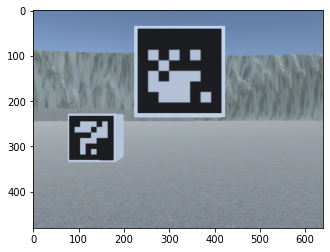

In [62]:
# Take and display a photo
image = rc.camera.get_color_image_async()
show_image(image)

The provided AR markers are 6x6 ArUco markers. The 6x6 markers have a 6x6 binary encoding in the center surrounded by a black border. The center encoding does not encode any data because of the matrix's low resolution. You would not be able to store much data. However, the large black and white pixels make these markers easy to distinguish at a distance and detectable when tilted with respect to the camera.

The following functions utilize existing OpenCV ArUco functions to locate and draw the AR markers. All the markers you will see in the course come from an ArUco dictionary of 250 unique 6x6 ar markers. Each marker has a defined 'upright' position in the dictionary, but can still be detected when rotated.

In [63]:
dictionary = cv.aruco.Dictionary_get(cv.aruco.DICT_6X6_250)
params = cv.aruco.DetectorParameters_create()

def get_ar_markers(
    color_image: NDArray[(Any, Any, 3), np.uint8]
) -> Tuple[List[NDArray[(1, 4, 2), np.int32]], Optional[NDArray[(Any, 1), np.int32]]]:
    """
    Finds AR marker coordinates and ids in an image.

    """
    corners, ids, _ = cv.aruco.detectMarkers(
        color_image,
        dictionary,
        parameters=params
    )
    return (corners, ids)

def draw_ar_markers(
    color_image: NDArray[(Any, Any, 3), np.uint32],
    corners: List[NDArray[(1, 4, 2), np.int32]],
    ids: NDArray[(Any, 1), np.int32],
    color: Tuple[int, int, int] = (0, 255, 0),
) -> NDArray[(Any, Any, 3), np.uint8]:
    """
    Draw AR markers in a image, modifying original image.
    """
    return cv.aruco.drawDetectedMarkers(color_image, corners, ids, color)

Let's just see how these functions work on an image.

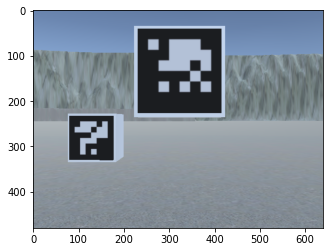

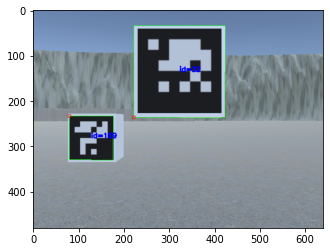

In [100]:
# Retrieve a new image
image = rc.camera.get_color_image_async()
show_image(image)

# Find AR marker corners and ids
corners, ids = get_ar_markers(image)

# Draw borders around the AR markers in the original image
marked_image = draw_ar_markers(image, corners, ids, (0, 255, 0))

show_image(marked_image)

<a id="UsingMarkerCoordinates"></a>
## 3. Using Marker Coordinates
The ArUco library can be useful for quickly identifying ar markers. However, the return types of `detectMarkers` aren't very straight forward. They can be passed as is to the `drawDetectedMarkers` function, but aren't easy to work with. They are left unmodified when passed between `get_ar_markers` and `draw_ar_markers`. Try to gain a familiarity with the return types.

The `get_ar_markers` function returns a tuple of the AR marker corners and ids. For a detected marker, the coordinates and id can be found at the same index in both lists. Assume *n* is the number of *detected* markers. 

* **corners**: This is a list of numpy arrays of length *n*. If there are no markers an empty list is returned. Each numpy array has the shape (1, 4, 2).
    - **0th dimension**: redundancy
    - **1st dimension**: four corners listed clockwise and beginning with the top-left corner (of the upright marker)
    - **2nd dimension**: the coordinates of the corner (column then row)
* **ids**: A numpy array with shape (*n*, 1). Each element in ids contains a list of a single id number.

Now try to gain some information about our variables: corners and ids.

In [101]:
# Print the AR marker coordinates and ids
print(f"corners: {corners}")
print(f"ids: {ids}")

# Check shape of numpy arrays
print(f"len(corners): {len(corners)}")
print(f"corners[0] shape: {corners[0].shape}")
print(f"ids shape: {ids.shape}")

corners: [array([[[ 80., 233.],
        [177., 233.],
        [176., 330.],
        [ 80., 329.]]], dtype=float32), array([[[222., 236.],
        [222.,  34.],
        [424.,  34.],
        [423., 237.]]], dtype=float32)]
ids: [[109]
 [ 32]]
len(corners): 2
corners[0] shape: (1, 4, 2)
ids shape: (2, 1)


When OpenCv detects AR markers, the markers from the image are compared against markers from a dictionary. The markers have a defined 'upright' position in the dictionary with a true top-left, top-right, bottom-right, and bottom-left corner. So when we receive the coordinates of each marker, the coordinates for the 'upright' marker's top-left corner will always be listed first followed by the other corners in clockwise order. When we draw our markers on the image, a small red box will appear around this special corner. These can be helpful for determining the direction/orientation of the marker.

**<font style="color:red">Write a short statement to check if the true top-left corner is above the true bottom-left.</font>** Left click in the RacecarSim Lab 7 level to rotate one of the ar markers.

In [102]:
# TODO: Check whether the true top-left corner is above the true bottom-left corner

corners[0][0,0, 1] < corners[0][0,3, 1] 


True

<a id="MarkerDirection"></a>
## 4. Marker Direction
OpenCv does not indicate what direction our ar markers are turned. However, we may find it useful to distinguish whether the AR marker is turned left, right, down, or up. This gives us more ways to extract data from the AR marker beyond just the id number. In fact, it will be used in the racecar time trials. 

For this function we provide 

**<font style="color:red">Finish writing the function `get_ar_direction` below, which takes the coordinate data from a single AR marker and returns the direction of the AR marker.</font>**

In [103]:
class Direction(IntEnum):
    """
    AR marker direction
    """
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

# TODO: Check the direction of the AR marker and return the correct enum
def get_ar_direction(ar_corners):
    mags = np.sqrt(np.sum(np.square(ar_corners[0]), axis = 1))
    return Direction(np.argmin(mags))


You are now ready to begin work on your time trials. Good luck, and don't be afraid to ask questions!

In [104]:
get_ar_direction(corners[1])

<Direction.RIGHT: 1>